<a href="https://colab.research.google.com/github/vmazashvili/Neural-Networks/blob/main/MaskTune_Vano_Mazashvili_1993251.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MaskTune Model

- train an ERM Model (Empirical Risk Minimization)
    - Load and normalize the CIFAR10 training and test datasets using torchvision

    - Define a Convolutional Neural Network

    - Define a loss function

    - Train the network on the training data

Test the network on the test data
- Generate Masks based on Model Outputs
- Fine-tune the Model with Masks
- Testing and Evaluation

In [51]:
!pip install torch torchvision timm
!pip install torchcam
!pip install pytorch-gradcam

In [96]:
import os
import cv2
import timm
import torch
import random
import numpy as np
import torchvision
from torch.optim import SGD
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.nn import CrossEntropyLoss
from torchcam.methods import XGradCAM
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import resize
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# MNIST DATASET

- [x] Distinguish between two MNIST digit groups (0-4 and 5-9)
- [x] 0-4 into class 0 and 5-9 into class 1.
- [ ] Transform 99% of new class 0 and 1% of the new class 1 so that they acquire same spurious feature (square in top left corner)
- [ ] Two test sets during testing: the original raw MNIST test set and a biased test set.
- [ ] biasd test set - add spurious feature to only 5-9 group  

Load and normalize the MNIST training and test datasets using torchvision. We can Induce spurrious features too



In [97]:
import torch
from torchvision import datasets

def remap_classes(dataset):
    """
    Remap MNIST dataset classes to two new classes
    new_to_old_label_mapping={0: [0, 1, 2, 3, 4], 1: [5, 6, 7, 8, 9]},

    Input:
        MNIST dataset

    Output:
        List of remapped dataset. Each item is (PIL image, class)
    """
    remapped_data = []
    remapped_targets = []

    for data, target in dataset:
        if target < 5:  # Digits 0-4
            remapped_targets.append(0)
        else:  # Digits 5-9
            remapped_targets.append(1)

        remapped_data.append(data)

    return list(zip(remapped_data, remapped_targets))

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='data', train=True, download=True)
mnist_test = datasets.MNIST(root='data', train=False, download=True)

# Remap the classes, the variables contain lists:
#
remapped_train_data = remap_classes(mnist_train)
remapped_test_data = remap_classes(mnist_test)

# Example usage:
print("Original class distribution in train set:", mnist_train.targets.bincount())
print("Remapped class distribution in train set:", torch.tensor([target for _, target in remapped_train_data]).bincount())

print("Original class distribution in test set:", mnist_test.targets.bincount())
print("Remapped class distribution in test set:", torch.tensor([target for _, target in remapped_test_data]).bincount())


Original class distribution in train set: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
Remapped class distribution in train set: tensor([30596, 29404])
Original class distribution in test set: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])
Remapped class distribution in test set: tensor([5139, 4861])


In [98]:
remapped_train_data[0]

(<PIL.Image.Image image mode=L size=28x28>, 1)

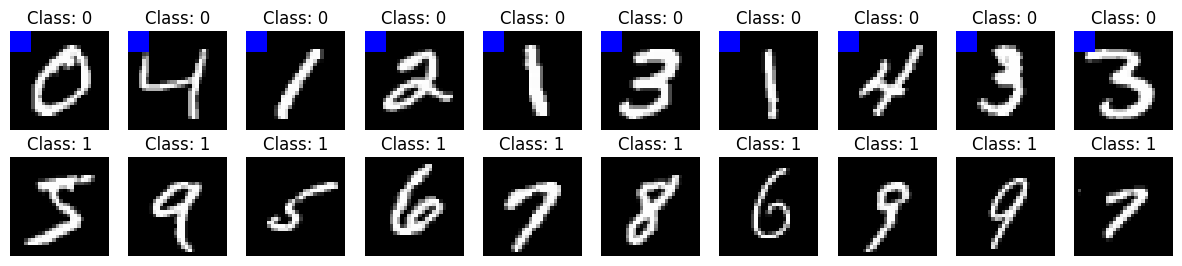

In [99]:
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def add_spurious_feature(image, label, percentage_class_0=0.99, percentage_class_1=0.01):
    """
    A function to add blue spurious features to PIL images based on class-specific percentages.

    Args:
        image (PIL.Image.Image): Input image.
        label (int): The class label of the image.
        percentage_class_0 (float, optional): Percentage of class 0 samples to apply the feature to. Defaults to 0.99.
        percentage_class_1 (float, optional): Percentage of class 1 samples to apply the feature to. Defaults to 0.0w1.

    Returns:
        PIL.Image.Image: Transformed image with the spurious feature.
    """
    # Determine the appropriate percentage based on the class label
    percentage = percentage_class_0 if label == 0 else percentage_class_1

    # Check if the condition for adding the feature is met
    if random.random() < percentage:
        # Create a copy of the input image
        image_with_spurious = image.convert("RGB")  # Ensure the image is in RGB mode
        # Create a drawing context
        draw = ImageDraw.Draw(image_with_spurious)
        # Draw a blue square in the top-left corner
        draw.rectangle([0, 0, 5, 5], fill=(0, 0, 255))  # Blue color
        del draw  # Release drawing context
        return image_with_spurious
    else:
        return image.convert("RGB")  # Ensure the image is in RGB mode

# Apply add_spurious_feature to the entire remapped_train_data dataset
remapped_train_data_with_spurious = [(add_spurious_feature(image, label), label) for image, label in remapped_train_data]

# Display 10 samples from each class
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
class_0_count = 0
class_1_count = 0

for image, label in remapped_train_data_with_spurious:
    if label == 0 and class_0_count < 10:
        axes[0, class_0_count].imshow(image)
        axes[0, class_0_count].set_title(f"Class: {label}")
        axes[0, class_0_count].axis('off')
        class_0_count += 1
    elif label == 1 and class_1_count < 10:
        axes[1, class_1_count].imshow(image)
        axes[1, class_1_count].set_title(f"Class: {label}")
        axes[1, class_1_count].axis('off')
        class_1_count += 1

    if class_0_count >= 10 and class_1_count >= 10:
        break

plt.show()


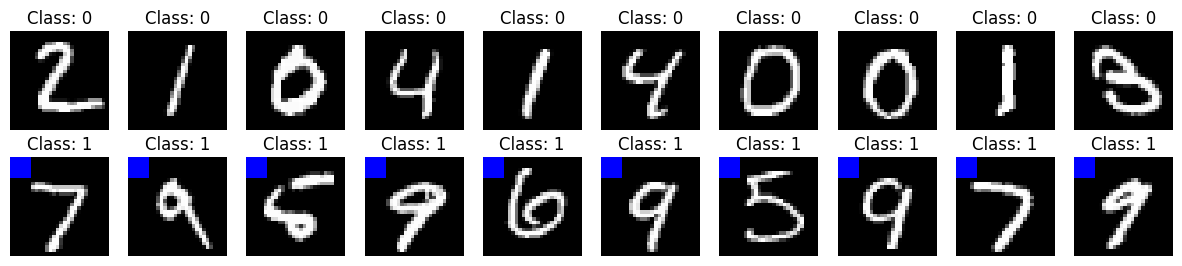

In [100]:
import random
from PIL import Image, ImageDraw

def add_spurious_feature_test(image, label, spurious_value=(0, 0, 255)):
    """
    A function to add a blue spurious feature to a PIL image for class 1 samples.

    Args:
        image (PIL.Image.Image): Input image.
        label (int): The class label of the image.
        spurious_value (tuple, optional): RGB value to assign to the spurious feature pixels. Defaults to blue (0, 0, 255).

    Returns:
        PIL.Image.Image: Transformed image with the spurious feature added (if applicable).
    """
    if label == 1:
        # Always add the feature to class 1 samples
        image_with_spurious = image.convert("RGB")  # Ensure the image is in RGB mode
        draw = ImageDraw.Draw(image_with_spurious)
        draw.rectangle([0, 0, 5, 5], fill=spurious_value)
        del draw
        return image_with_spurious
    else:
        return image.convert("RGB")  # Ensure the image is in RGB mode

# Save remapped_test_data into test_data_raw
test_data_raw = remapped_test_data.copy()  # Create a copy to avoid modifying the original data

# Apply spurious features to class 1 samples in test_data_raw and store in test_data_biased
test_data_biased = [(add_spurious_feature_test(image, label), label) for image, label in test_data_raw]

# Display 10 samples from each class in the biased test set
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
class_0_count = 0
class_1_count = 0

for image, label in test_data_biased:
    if label == 0 and class_0_count < 10:
        axes[0, class_0_count].imshow(image)
        axes[0, class_0_count].set_title(f"Class: {label}")
        axes[0, class_0_count].axis('off')
        class_0_count += 1
    elif label == 1 and class_1_count < 10:
        axes[1, class_1_count].imshow(image)
        axes[1, class_1_count].set_title(f"Class: {label}")
        axes[1, class_1_count].axis('off')
        class_1_count += 1

    if class_0_count >= 10 and class_1_count >= 10:
        break

plt.show()


In [101]:
remapped_train_data_with_spurious[0]
remapped_test_data[0]
test_data_biased[0]

(<PIL.Image.Image image mode=RGB size=28x28>, 1)

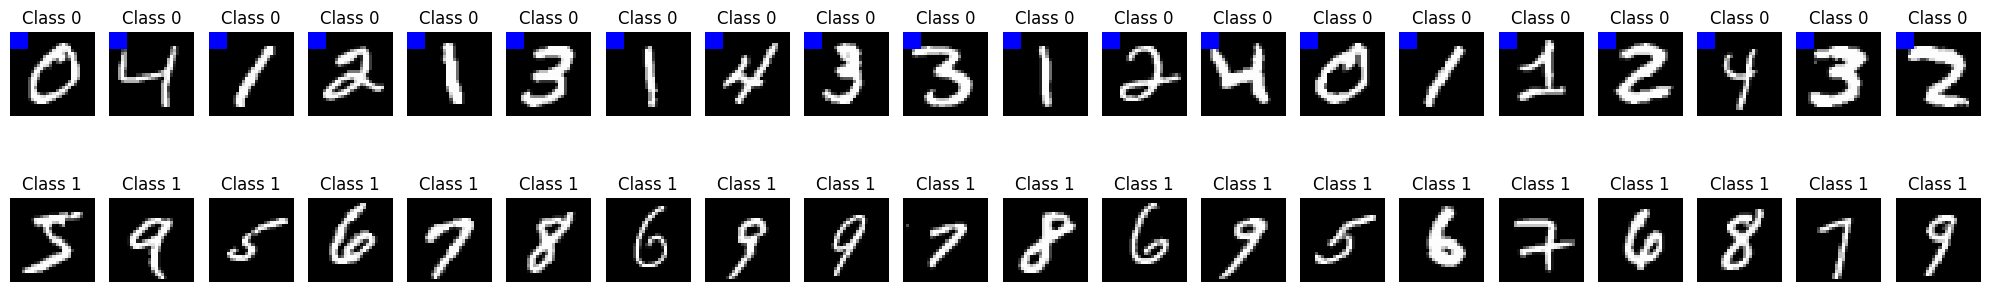

In [102]:
import matplotlib.pyplot as plt

# Initialize counters for each class
class_counts = {0: 0, 1: 0}

# Plot 10 samples for each class
fig, axes = plt.subplots(2, 20, figsize=(20, 4))

for image, label in remapped_train_data_with_spurious:
    # Check if the maximum number of samples for each class is reached
    if class_counts[label] >= 20:
        continue

    # Plot the image
    ax = axes[label][class_counts[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts[label] += 1

plt.tight_layout()
plt.show()


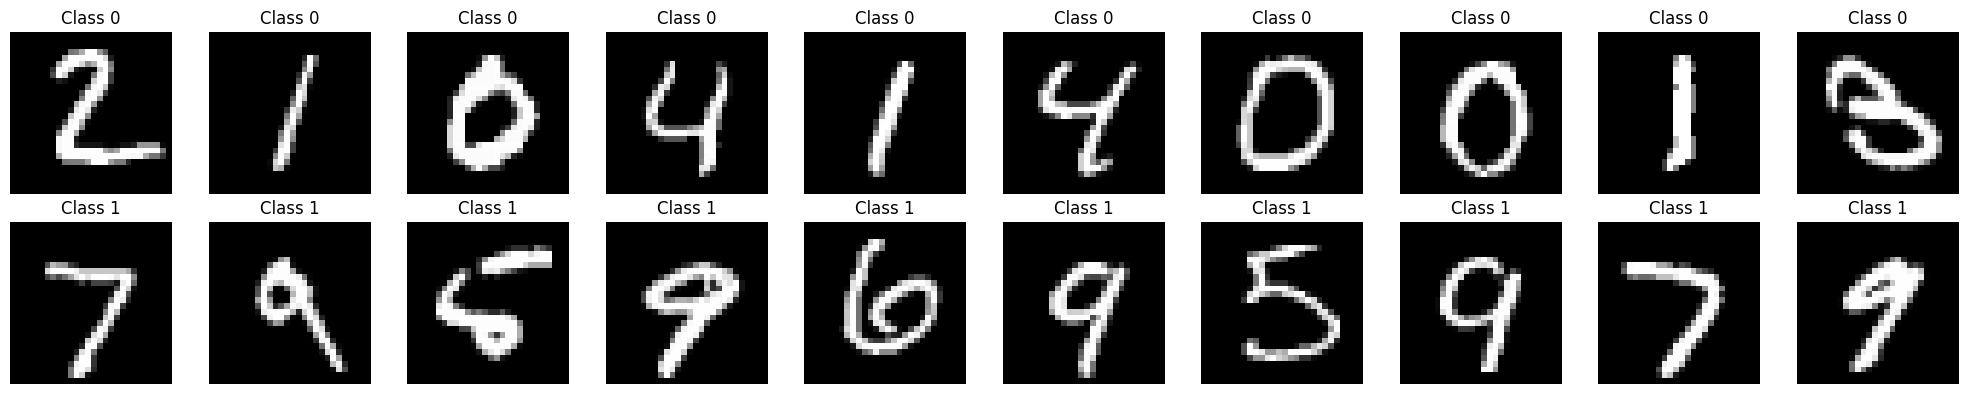

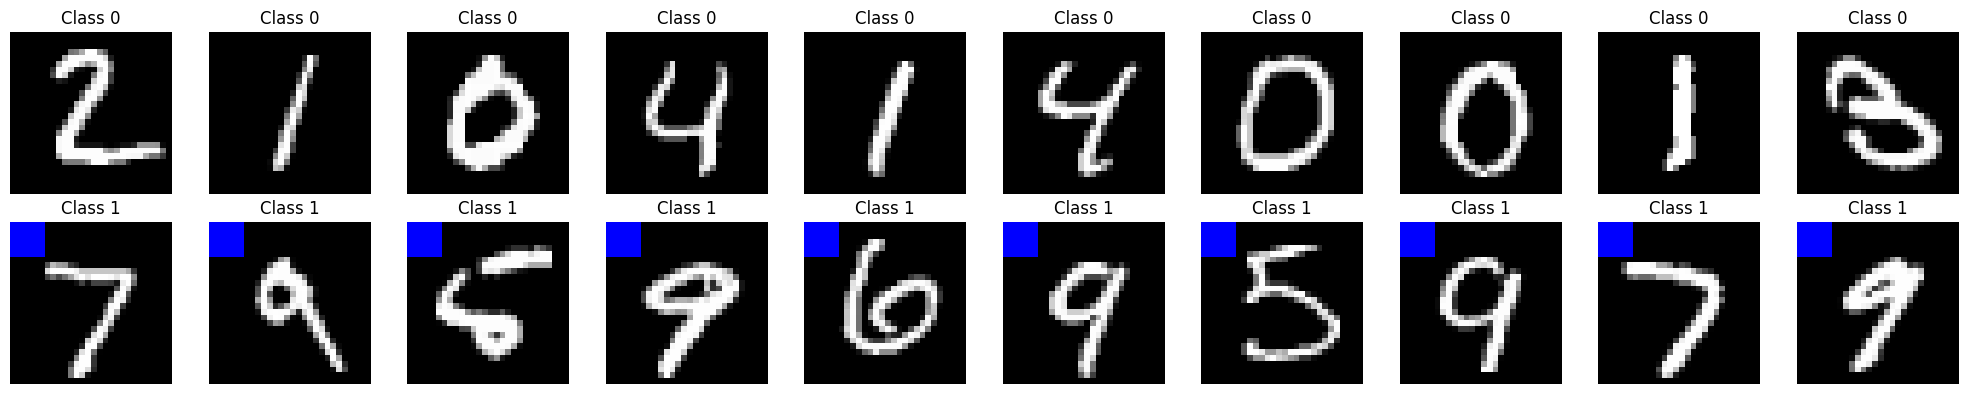

In [103]:
import matplotlib.pyplot as plt

# Initialize counters for each class
class_counts_raw = {0: 0, 1: 0}
class_counts_biased = {0: 0, 1: 0}

# Plot 10 samples for each class from test_data_raw
fig_raw, axes_raw = plt.subplots(2, 10, figsize=(20, 4))

for image, label in test_data_raw:
    # Check if the maximum number of samples for each class is reached
    if class_counts_raw[label] >= 10:
        continue

    # Plot the image
    ax = axes_raw[label][class_counts_raw[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts_raw[label] += 1

plt.tight_layout()
plt.show()

# Plot 10 samples for each class from test_data_biased
fig_biased, axes_biased = plt.subplots(2, 10, figsize=(20, 4))

for image, label in test_data_biased:
    # Check if the maximum number of samples for each class is reached
    if class_counts_biased[label] >= 10:
        continue

    # Plot the image
    ax = axes_biased[label][class_counts_biased[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts_biased[label] += 1

plt.tight_layout()
plt.show()


Therefore, we should have a training dataset ```remapped_train_data_with_spurious``` with two classes, 0 (containing digits 0-4) and 1 (digits 5-9).
99% of the samples in class 0 have a spurious feature, while 1% of the class 1 has the same spurious feature.

As for testing dataset, we have 2, ```test_data_raw``` and ```test_data_biased```. One will be a raw MNIST test dataset, while the other one will be a modified one with spurious features for class 1 samples.

Thus we have ```test_data_daw```, ```test_data_spurious``` with only class 1 sample spurious features, `remapped_train_data_with_spurious`, and `remapped_train_data`

# Dataloaders
make batches

In [104]:
from PIL import Image

# Convert grayscale images in remapped_test_data to RGB
remapped_test_data_rgb = [(image.convert("RGB"), label) for image, label in remapped_test_data]

# Define a transform to convert PIL images to tensors
transform = transforms.ToTensor()

# Convert remapped_train_data_with_spurious to tensors
remapped_spurious_train_data_tensor = [(transform(image), label) for image, label in remapped_train_data_with_spurious]

# Convert remapped_test_data_rgb to tensors
test_data_raw_tensor = [(transform(image), label) for image, label in remapped_test_data_rgb]

# Convert test_data_biased to tensors
test_data_biased_tensor = [(transform(image), label) for image, label in test_data_biased]


In [61]:
biased_train_dataloader = DataLoader(remapped_spurious_train_data_tensor, batch_size=128)
raw_test_dataloader = DataLoader(test_data_raw_tensor, batch_size=128)
biased_test_dataloader = DataLoader(test_data_biased_tensor, batch_size=128)

len(biased_train_dataloader)
len(raw_test_dataloader)
len(biased_test_dataloader)

for data_batch, label_batch in biased_train_dataloader:
    print("Data batch shape:", data_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Data batch example:", data_batch[0])
    print("Label batch example:", label_batch[0])
    break  # Only print the first batch for brevity


Data batch shape: torch.Size([128, 3, 28, 28])
Label batch shape: torch.Size([128])
Data batch example: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Label batch example: tensor(1)


### Creating a subset dataset for testing purposes

In [124]:
# Define subset sizes
subset_size_train = 300
subset_size_test_raw = 100
subset_size_test_biased = 100

# Randomly sample subsets from the tensors
subset_train_biased_tensor = random.sample(remapped_spurious_train_data_tensor, subset_size_train)
subset_test_raw_tensor = random.sample(test_data_raw_tensor, subset_size_test_raw)
subset_test_biased_tensor = random.sample(test_data_biased_tensor, subset_size_test_biased)

# Define batch size
batch_size = 64  # Adjust as needed

# Create DataLoader for the subset of training data
subset_train_biased_dataloader = DataLoader(subset_train_biased_tensor, batch_size=batch_size, shuffle=True)

# Create DataLoader for the subset of raw test data
subset_test_raw_dataloader = DataLoader(subset_test_raw_tensor, batch_size=batch_size, shuffle=False)

# Create DataLoader for the subset of biased test data
subset_test_biased_dataloader = DataLoader(subset_test_biased_tensor, batch_size=batch_size, shuffle=False)

# Define CNN
Define a Convolutional Neural Network and give its class a ```get_grad_cam_target_layer``` function which will grab the last convolutional layer to use it for saliency map generation. Uses almost the same architecture as the paper "MaskTune: Mitigating Spurious Correlations by Forcing to Explore"

In [62]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), (1, 1)),  # Change 1 to 3 for RGB input
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.linear(features)
        return logits

    def get_grad_cam_target_layer(self):
        return self.backbone[-3]

### Hyperparameters, optimizer, model selection

In [63]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters according to the paper
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
batch_size = 128
epochs = 20
lr_decay_epochs = 25
lr_decay_factor = 0.5
number_of_classes = 2

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer with the above presented hyperparameters
model = SmallCNN(number_of_classes)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler to decrease learning rate every lr_decay_epochs epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)

# Training and Testing
Done with the specified parameters and models above

`test_model()` has:

**Class-wise accuracy** - correctness of predictions for each class infividually. We expect improved class-wise accuracy for biased dataset after applying MaskTune. Before that, biased dataset should have low class-wise accuracy for the underrepresented classes.

**Precision and Recall, F1 score** -

*   Precision - how many of the predicted positive samples are actually positive
*   Recall - how many of the actual positive samples are predicted as positive
*   F1 score - balance between them
We expect to see improvements in those metrics after applying MaskTune, especially for the biased dataset.

**Confusion Matrix** - detailed breakdown of correct and incorrect classifications for each class. After applying Masktune, we should see the improvements in the main diagonal of the matrix (correct classifications)

**Accuracy** - overall correctness of the predictions. Improvements in accuracy after applying Masktune is expected on both raw and biased datasets. Before that, accuracy might be lower on the biased dataset compared to the raw dataset due to the bias.

In [64]:
def train_erm(model, dataloader, optimizer, loss_function, epochs=100):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for xb, yb in dataloader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_function(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct_predictions += (preds.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)

        epoch_loss = total_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        torch.save(model.state_dict(), f'/content/data/MNIST/CNN_checkpoint.pth')


In [65]:
def test_model(model, dataloader, loss_function, num_classes=2):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    class_correct = [0] * num_classes
    class_samples = [0] * num_classes

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            preds = model(xb)
            loss = loss_function(preds, yb)

            total_loss += loss.item() * xb.size(0)
            correct_predictions += (preds.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)

            for i in range(len(yb)):
                label = yb[i].item()
                pred = preds.argmax(1)[i].item()
                all_preds.append(pred)
                all_labels.append(label)
                if label == pred:
                    class_correct[label] += 1
                class_samples[label] += 1

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    class_accuracy = [class_correct[i] / class_samples[i] if class_samples[i] > 0 else 0 for i in range(num_classes)]

    print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    for i in range(num_classes):
        print(f"Class {i} Accuracy: {class_accuracy[i]:.4f}")

    conf_matrix = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


In [66]:
# Train the model with biased training dataset
train_erm(model, biased_train_dataloader, optimizer, loss_function, epochs=1)

# Test the model on the raw test dataset
print("\033[1m \033[93m Testing on Raw Test Dataset: \033[0m")  # Bold and yellow text
test_model(model, raw_test_dataloader, loss_function)

# Test the model on the biased test dataset
print("\033[1m \033[93m Testing on Biased Test Dataset: \033[0m") # Reset formatting
test_model(model, biased_test_dataloader, loss_function)


Epoch 1/1, Loss: 0.0365, Accuracy: 0.9878
  Testing on Raw Test Dataset: 
Test Loss: 0.5019, Accuracy: 0.8079
Class 0 Accuracy: 0.6283
Class 1 Accuracy: 0.9977
Confusion Matrix:
[[3229 1910]
 [  11 4850]]
Precision: 0.8570
Recall: 0.8130
F1 Score: 0.8027
  Testing on Biased Test Dataset: 
Test Loss: 0.8588, Accuracy: 0.6632
Class 0 Accuracy: 0.6283
Class 1 Accuracy: 0.7001
Confusion Matrix:
[[3229 1910]
 [1458 3403]]
Precision: 0.6647
Recall: 0.6642
F1 Score: 0.6631


# Masktune
After the initial training with the empirical risk minimization, let's apply Masktune, which incorporates:

- **Mask Generation** - identifying and masking the most influential, potentially spurious features

- **Mask Application and Finetunning** - by finetuning the model with the masked data, it is forced to explore less prominent and potentially more descriptive non-spurious features.

- **Iteratarions** - enable us to adjust the depth of the feature depth and descriptiveness.

## Mask Generation

1.   **Train the model using** Empirical Risk Minimization (**ERM**)
2.   **Identify the spurious features** / class activations from saliency maps. In case of present spurious features, the method will likely identify the spurious feature, while for the input without any spurious features, the function will identify the most prominent features to mask, forcing the training to escape its myopic and greedy feature-seeking approach and encouraging and leveraging more input variables [1]
3.  **Generate masks** to cover the most discriminatory features discovered in the saliency maps.
4.  The generated masks from the step 3 will be applied to the dataset
5.  We will fine-tune the pretrained ERM model on newly masked dataset onlt for one epoch.

In [125]:
class MaskTunePipeline:
    def __init__(self, model, biased_train_dataloader, raw_test_dataloader, biased_test_dataloader, mask_dir, batch_size=128, epochs=1, finetune_epochs=1, num_classes=2):
        self.model = model
        self.biased_train_dataloader = biased_train_dataloader
        self.raw_test_dataloader = raw_test_dataloader
        self.biased_test_dataloader = biased_test_dataloader
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.finetune_epochs = finetune_epochs
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        self.loss_function = nn.CrossEntropyLoss()
        self.num_classes = num_classes

    def train_erm(self):
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for xb, yb in self.biased_train_dataloader:
                self.optimizer.zero_grad()
                preds = self.model(xb)
                loss = self.loss_function(preds, yb)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * xb.size(0)
                correct_predictions += (preds.argmax(1) == yb).sum().item()
                total_samples += xb.size(0)

            epoch_loss = total_loss / total_samples
            epoch_accuracy = correct_predictions / total_samples

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            torch.save(self.model.state_dict(), f'{self.mask_dir}/CNN_checkpoint.pth')

    def test_model(self, dataloader):
        self.model.eval()
        test_loss = 0
        correct = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        confusion_matrix = np.zeros((2, 2), dtype=int)

        with torch.no_grad():
            for xb, yb in dataloader:
                # No detachment here (assuming it's not necessary)
                # xb = xb.detach()  # Remove this line if not needed
                preds = self.model(xb)
                loss = self.loss_function(preds, yb)
                test_loss += loss.item()
                pred_class = preds.argmax(dim=1)
                correct += (pred_class == yb).sum().item()

                for i in range(len(pred_class)):
                    confusion_matrix[yb[i]][pred_class[i]] += 1
                    class_total[yb[i]] += 1
                    if pred_class[i] == yb[i]:
                        class_correct[yb[i]] += 1

        accuracy = correct / len(dataloader.dataset)
        test_loss /= len(dataloader.dataset)

        print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
        for i in range(2):
            print(f"Class {i} Accuracy: {100 * class_correct[i] / class_total[i]:.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix)


    def generate_map(self, sample_idx, sample_class):
        """
        Generates a saliency map for a specific sample in the biased training data.

        Args:
            sample_idx (int): Index of the sample in the biased training dataset.
            sample_class (int): Class label of the sample.

        Returns:
            np.ndarray: Saliency map for the sample.
        """

        checkpoint = torch.load(f'{self.mask_dir}/CNN_checkpoint.pth')
        self.model.load_state_dict(checkpoint)
        self.model.eval()

        if not isinstance(sample_idx, int):
            raise ValueError("sample_idx must be an integer representing the sample index")

        try:
            data, label = self.biased_train_dataloader.dataset[sample_idx]
        except IndexError:
            raise IndexError(f"sample_idx {sample_idx} is out of range for the biased training dataset")

        if len(data.shape) == 3:
            data = data.unsqueeze(0)

        data = data.to(next(self.model.parameters()).device)

        target_layer = self.model.get_grad_cam_target_layer()
        cam = XGradCAM(self.model, target_layer)
        output = self.model(data)
        batch_size = data.size(0)
        class_idx = [sample_class] * batch_size

        saliency_map = cam(class_idx=class_idx, scores=output)
        saliency_map_np = saliency_map[0].detach().cpu().numpy()
        saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

        return saliency_map_np

    def create_mask(self, saliency_map, threshold=0.5):
        mask = saliency_map > threshold
        return mask.astype(np.float32)


    def apply_mask(self, image, mask, resize_dims=(28, 28)):
        # print("Image shape:", image.shape)
        # print("Mask shape:", mask.shape)

        # Resize the mask to match the dimensions of the image
        mask_resized = F.interpolate(torch.tensor(mask).unsqueeze(0).unsqueeze(0), size=(image.shape[1], image.shape[2]), mode='nearest').squeeze(0).squeeze(0)

        # Apply mask to the image
        masked_image = image * (1 - mask_resized)

        # Resize the masked image
        masked_image_resized = F.interpolate(masked_image.unsqueeze(0), size=resize_dims, mode='bilinear', align_corners=False).squeeze(0)

        return masked_image_resized

    def mask_data(self):
        print("Generating and applying masks to the training data...")
        masked_data = []
        for i, (data, label) in enumerate(self.biased_train_dataloader.dataset):
            data, label = torch.tensor(data).clone().detach(), torch.tensor(label).clone().detach()
            # more efficient way (optional)
            # data, label = data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), label.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            saliency_map = self.generate_map(i, label.item())
            mask = self.create_mask(saliency_map)
            masked_image = self.apply_mask(data, mask)
            masked_data.append((masked_image, label))
        torch.save(masked_data, f'{self.mask_dir}/masked_train_data.pth')
        print("Masks generated and applied to the training data.")

    def finetune(self, masked_dataloader):
        self.model.train()
        for epoch in range(self.finetune_epochs):
            total_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for xb, yb in masked_dataloader:
                self.optimizer.zero_grad()
                preds = self.model(xb)
                loss = self.loss_function(preds, yb)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * xb.size(0)
                correct_predictions += (preds.argmax(1) == yb).sum().item()
                total_samples += xb.size(0)

            epoch_loss = total_loss / total_samples
            epoch_accuracy = correct_predictions / total_samples

            print(f"Finetune Epoch {epoch+1}/{self.finetune_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            torch.save(self.model.state_dict(), f'{self.mask_dir}/finetuned_model_checkpoint.pth')

    def masktune(self):
        self.train_erm()
        print("\033[1m \033[93m Testing on Raw Test Dataset: \033[0m")
        self.test_model(self.raw_test_dataloader)
        print("\033[1m \033[93m Testing on Biased Test Dataset: \033[0m")
        self.test_model(self.biased_test_dataloader)

        self.mask_data()

        masked_data = torch.load(f'{self.mask_dir}/masked_train_data.pth')
        masked_train_dataloader = DataLoader(masked_data, batch_size=self.batch_size, shuffle=True)

        print("\033[1m \033[93m Fine-tuning with masked data... \033[0m")
        self.finetune(masked_train_dataloader)

        print("\033[1m \033[93m Testing on Raw Test Dataset after fine-tuning: \033[0m")
        self.test_model(self.raw_test_dataloader)
        print("\033[1m \033[93m Testing on Biased Test Dataset after fine-tuning: \033[0m")
        self.test_model(self.biased_test_dataloader)

# Example usage:
# model = SmallCNN(num_classes=2)
# pipeline = MaskTunePipeline(model, biased_train_dataloader, raw_test_dataloader, biased_test_dataloader, mask_dir='/path/to/mask_dir')
# pipeline.masktune()


In [126]:
# Initialize the MaskTunePipeline and run masktune
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")
model = SmallCNN(num_classes=2)
#model = model.to(device)  # Move the model to the chosen device

# Testing
pipeline = MaskTunePipeline(model, subset_train_biased_dataloader, subset_test_raw_dataloader, subset_test_biased_dataloader, mask_dir='/content/data/MNIST')
#pipeline = MaskTunePipeline(model, biased_train_dataloader, raw_test_dataloader, biased_test_dataloader, mask_dir='/content/data/MNIST')
pipeline.masktune()


Epoch 1/1, Loss: 0.5321, Accuracy: 0.7067
  Testing on Raw Test Dataset: 
Test Loss: 0.0138, Accuracy: 0.5400
Class 0 Accuracy: 0.0000
Class 1 Accuracy: 100.0000
Confusion Matrix:
[[ 0 46]
 [ 0 54]]
  Testing on Biased Test Dataset: 
Test Loss: 0.0138, Accuracy: 0.5600
Class 0 Accuracy: 0.0000
Class 1 Accuracy: 100.0000
Confusion Matrix:
[[ 0 44]
 [ 0 56]]
Generating and applying masks to the training data...
Masks generated and applied to the training data.
  Fine-tuning with masked data... 
Finetune Epoch 1/1, Loss: 0.1386, Accuracy: 0.9933
  Testing on Raw Test Dataset after fine-tuning: 


RuntimeError: cannot register a hook on a tensor that doesn't require gradient

# Generating Saliency Map using XGradCAM
Implementing explainability.
Using the, for example, last convolutional layer from the trained CNN checkpoint to generate the gradient and hook.
Pass a random instance from each class to the trained model. The model, target layer from the trained network and the network output are used to generate a saliency_map which is interpolated and projected onto the appropriate input image.

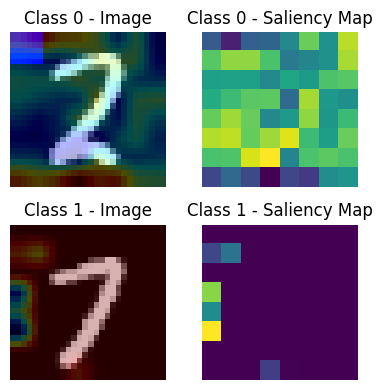

In [118]:
# Load the model
model = SmallCNN(num_classes=2)

def generate_map(sample_data, sample_class):
    checkpoint = torch.load('/content/data/MNIST/CNN_checkpoint.pth') # Load the saved model checkpoint
    model.load_state_dict(checkpoint)
    model.eval() # Set the model to evaluation mode

    # Get the target layer
    target_layer = model.get_grad_cam_target_layer() # Last convolutional layer is the target
    # Prepare the input tensor
    input_tensor = sample_data # a sample from the dataset passed to the function

    cam = XGradCAM(model, target_layer)
    output = model(input_tensor.unsqueeze(0))
    saliency_map = cam(class_idx=sample_class, scores=output)

    # Get the first saliency map tensor from the list
    saliency_map_tensor = saliency_map[0]

    # Convert the saliency map tensor to a numpy array
    saliency_map_np = saliency_map_tensor.detach().cpu().numpy()

    # Reshape the saliency map to 2D
    saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

    return saliency_map_np

def interpolate_heatmap(input_tensor, saliency_map_np):
    # Convert the input tensor to a numpy array image
    input_img_np = input_tensor.permute(1, 2, 0).cpu().numpy()  # Change the shape from (C, H, W) to (H, W, C)
    input_img_np = np.uint8(255 * input_img_np)

    # Resize the saliency map to match the size of the original image
    heatmap_resized = cv2.resize(saliency_map_np, (input_img_np.shape[1], input_img_np.shape[0]))

    # Normalize the saliency map values to the range [0, 255]
    heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized)) * 255
    heatmap_resized = np.uint8(heatmap_resized)

    # Apply a colormap to the saliency map to convert it into a heatmap image
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay the heatmap image onto the original image
    superimposed_img = cv2.addWeighted(input_img_np, 0.7, heatmap_colored, 0.3, 0)

    return superimposed_img

# Dictionary to store interpolated images by class label
interpolated_images_by_class = {}
saliency_maps_by_class = {}

# Function to generate and interpolate the heatmap for one instance of each class
def generate_and_interpolate_heatmap_one_per_class():
    # Create a dictionary to hold the data instances for each class
    class_data_dict = {}

    # Iterate through the training data
    for data, label in remapped_spurious_train_data_tensor:
        if label not in class_data_dict:
            class_data_dict[label] = []
        class_data_dict[label].append(data)

    # Iterate through each class label
    for class_label in range(2):  # Assuming 2 classes (0 and 1)
        # Get the data instances for the specified class label
        class_data = class_data_dict.get(class_label, [])

        # Select one random instance from the class data
        if class_data:
            random_instance = random.choice(class_data)

            # Generate the saliency map for the random instance
            saliency_map_np = generate_map(random_instance, class_label)

            # Interpolate the heatmap for the random instance
            interpolated_img = interpolate_heatmap(random_instance, saliency_map_np)

            # Store the interpolated image in the dictionary by class label
            interpolated_images_by_class[class_label] = interpolated_img

            saliency_maps_by_class[class_label] = saliency_map_np

# Generate interpolated images for one instance per class
generate_and_interpolate_heatmap_one_per_class()

# Plot the interpolated images and saliency maps together
fig, axs = plt.subplots(2, 2, figsize=(4, 4))  # Adjust figsize for square plot

for i, ax in enumerate(axs.flat):
  class_label = i // number_of_classes # Different for each dataset
  interpolated_img = interpolated_images_by_class.get(class_label)
  saliency_map_by_class = saliency_maps_by_class.get(class_label)  # Assuming separate dictionary

  if interpolated_img is not None:
    # Display the interpolated image on the top half of the subplot
    axs[i // 2, 0].imshow(interpolated_img)
    axs[i // 2, 0].axis('off')
    axs[i // 2, 0].set_title(f'Class {class_label} - Image')

    # Display the saliency map on the bottom half of the subplot
    axs[i // 2, 1].imshow(saliency_map_by_class)  # Assuming saliency map format is compatible
    axs[i // 2, 1].axis('off')
    axs[i // 2, 1].set_title(f'Class {class_label} - Saliency Map')

  else:
    axs[i].axis('off')

plt.tight_layout()
plt.show()



TODO:
start implementing MaskTune for MNIST

- [x] **ISSUE:** The transformation function transforms every instance in the dataset instead of the ones of the chosen class
- [x] Create a biased MNIST dataset - for it to work, induce spurious feature to one class so the model will pick up the easyeast detectable feature. If the bias is applied to every class, the result wont change because during training, the model is forced to focus on other features in order to predict correctly.
- [ ] See how it performs compared to unbised MNIST

---

- [ ] def `finetune` (finetune erm checkpoint with ```masktune```)
- [ ] def ```masktune```
- [ ] def ```finetune```

---

- [ ] Compare performances and saliency matrices between unbiased and biased MNIST datasets



